In [1]:
import sys
if '../' not in sys.path:
    sys.path.append('../')

import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(asctime)s: %(message)s')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchaudio

from tqdm import tqdm
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import numpy as np
import math

import data
import augmentation

# Pick an instrument

In [2]:
instrument = 'piano'
#instrument = 'violin'
#instrument = 'flute'
#instrument = 'distorted electric guitar'
#instrument = 'female singer'
#instrument = 'clarinet'
#instrument = 'trumpet'
#instrument = 'tenor saxophone'

# Pick a dataset split

In [3]:
#split = 'training'
split = 'validation'
#split = 'test'

In [4]:
dataset = data.MedleyDBSolosDataset('/home/code-base/scratch_space/data/medleydb_solos', instruments=[instrument], split=split, rate=16000)
noise_dataset = data.NoiseDataset('/home/code-base/scratch_space/noise_samples_47555_length_16000_hz.npz', split=split)
reverb_dataset = data.ReverbDataset('/home/code-base/scratch_space/small_room_reverb_samples_16000_hz.npz', split=split)

INFO: 2021-07-28 16:53:11,874: Reading MedleyDB Solos Samples from split validation
100%|██████████| 1022/1022 [00:21<00:00, 47.08it/s]
INFO: 2021-07-28 16:53:33,656: Read 1022 music samples
INFO: 2021-07-28 16:53:33,740: Batch loading from noise sample file for split validation
INFO: 2021-07-28 16:53:34,182: Read 1460 noise samples
INFO: 2021-07-28 16:53:34,182: Batch loading from room impulse response file for split validation
INFO: 2021-07-28 16:53:34,279: Read 2000 room impulse response samples


In [5]:
data_loader = iter(DataLoader(dataset, batch_size=1, drop_last=True, shuffle=True))
noise_loader = iter(DataLoader(noise_dataset, batch_size=1))
reverb_loader = iter(DataLoader(reverb_dataset, batch_size=1))
eq_model = augmentation.MicrophoneEQ(rate=16000)
spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=1024, win_length=1024, hop_length=256, n_mels=80)

# Run cell below to generate:
1) Clean audio sample
2) Plot of additive noise and reverb samples
3) Six samples with additive noise (SNR ranging from 30 to 0 dB)
4) Six samples with reverb (DRR ranging from 30 to 0 dB)
5) Six samples with randomly sampled EQ
6) Six samples with all augmentations (additive noise, reverb, EQ)

Each augmented sample shows plots of the:
* clean waveform
* augmented waveform
* augmented log mel-spectrogram
* difference between the augmented and clean log mel-spectrograms

Clean Sample


Noise and Reverb Sample


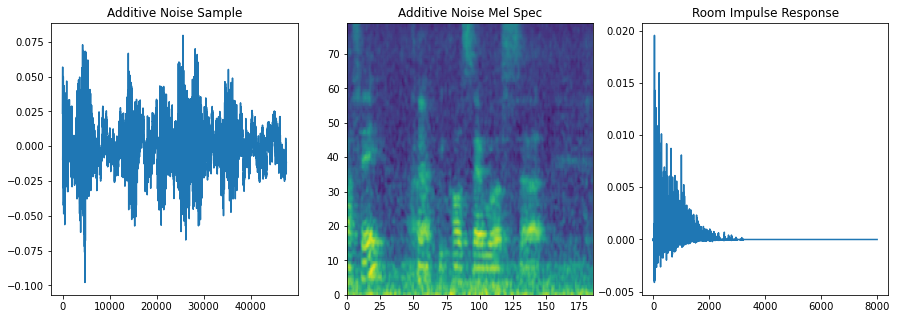

Additive noise with SNR of 30.0


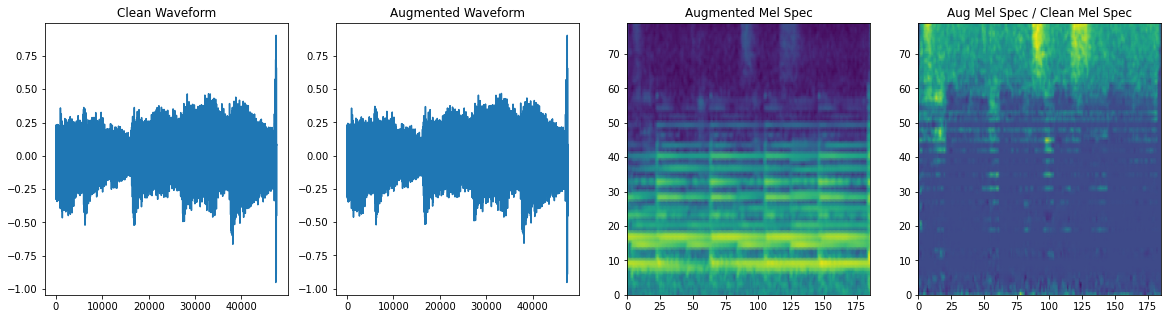

Additive noise with SNR of 25.0


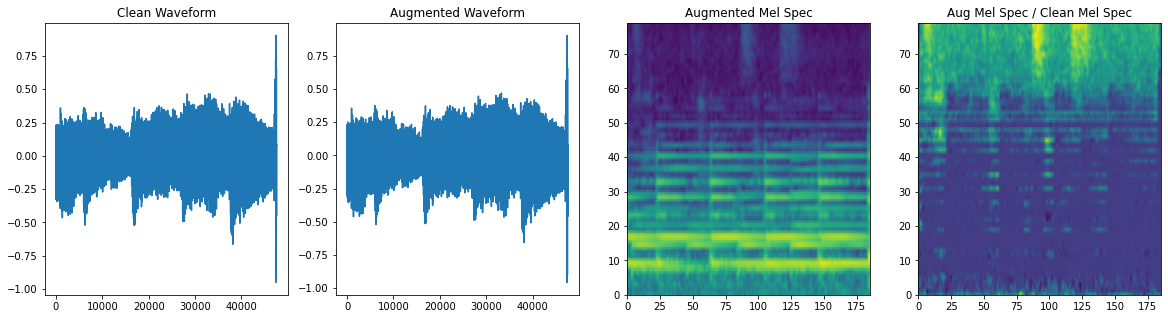

Additive noise with SNR of 20.0


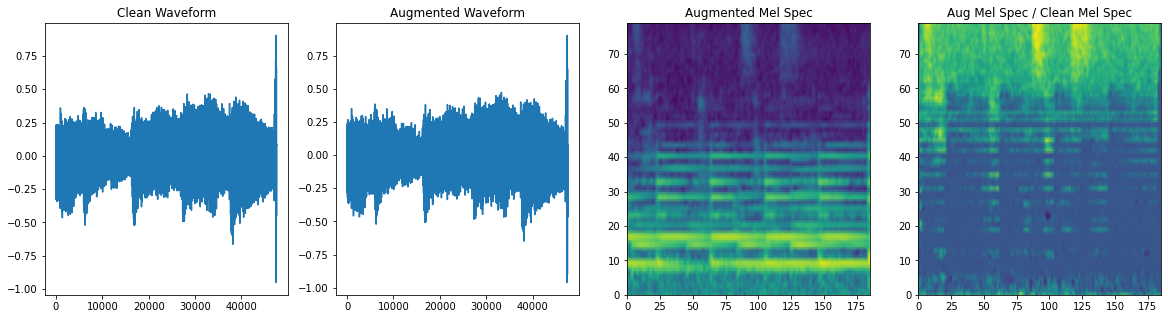

Additive noise with SNR of 15.0


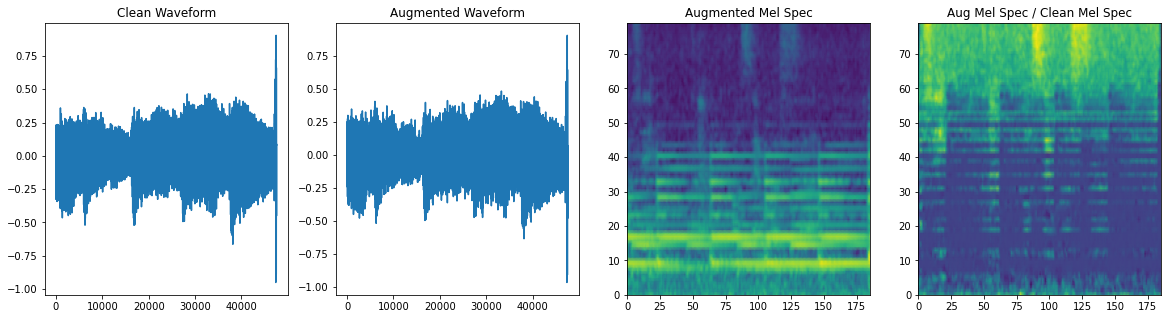

Additive noise with SNR of 10.0


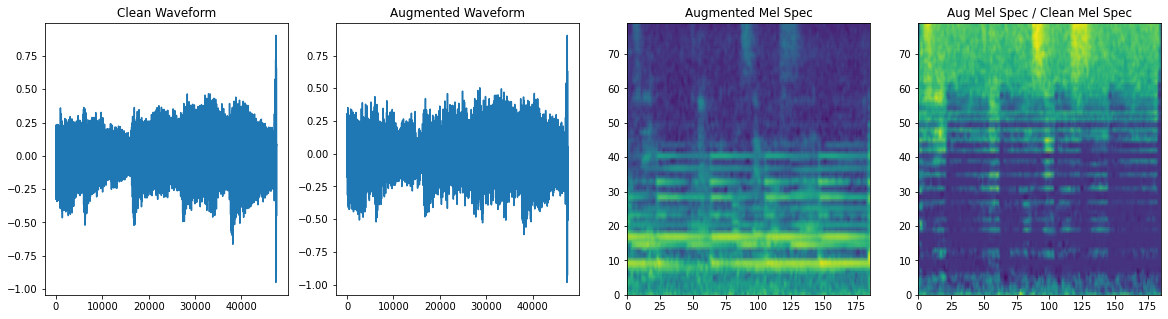

Additive noise with SNR of 5.0


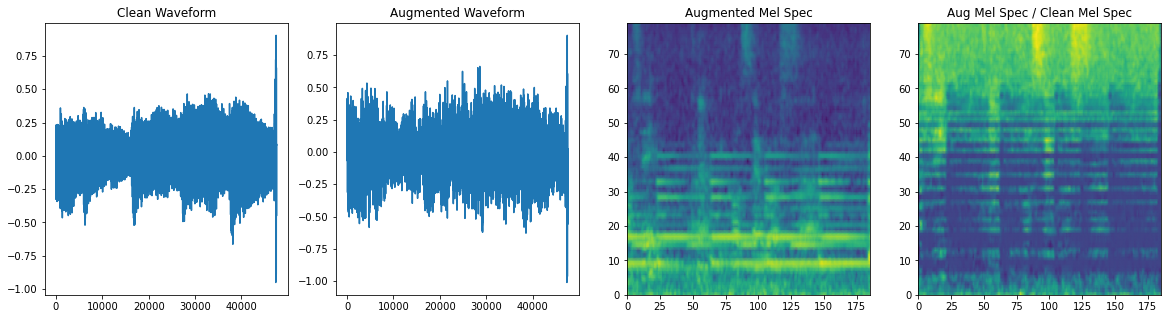

Reverb with DRR of 15.0


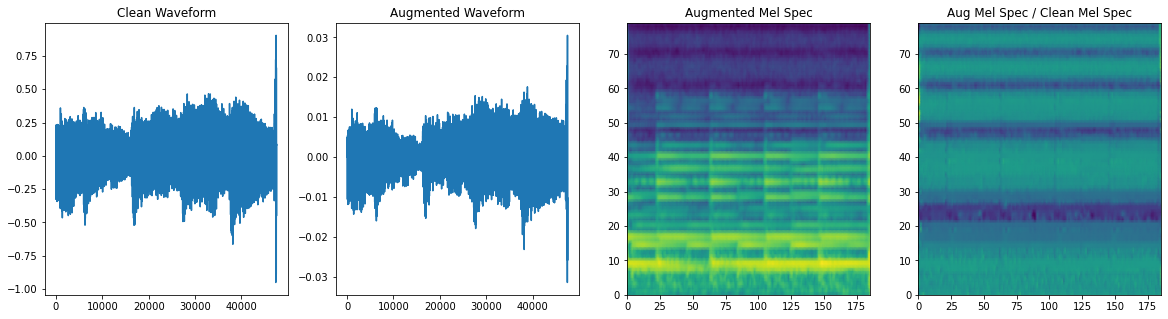

Reverb with DRR of 12.0


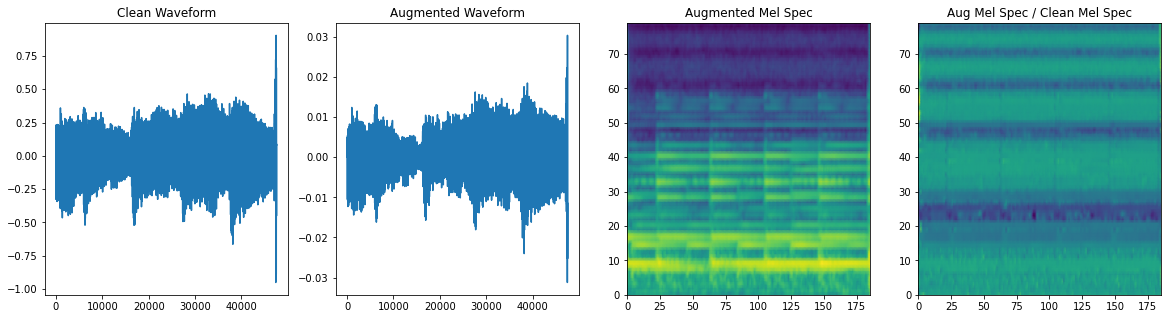

Reverb with DRR of 9.0


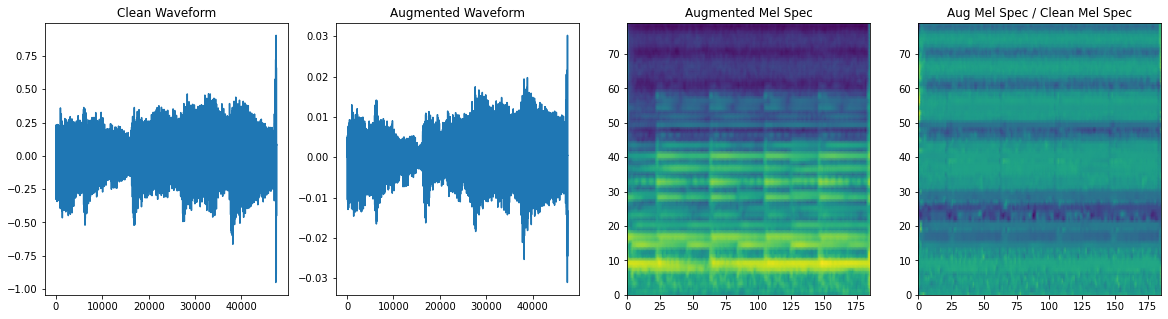

Reverb with DRR of 6.0


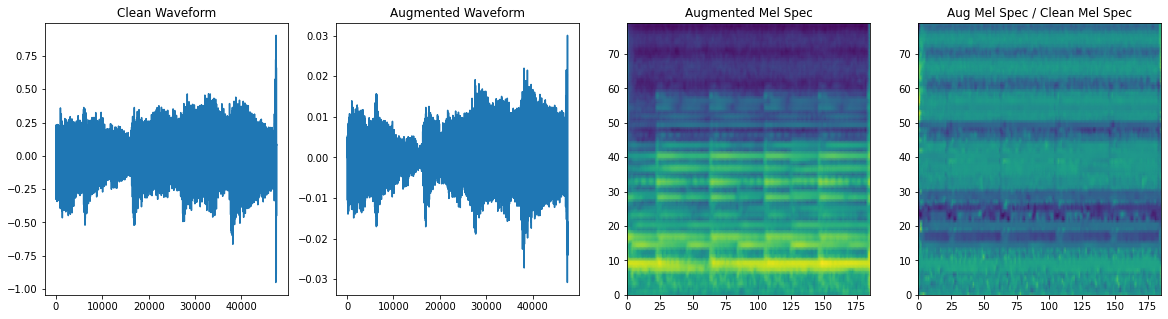

Reverb with DRR of 3.0


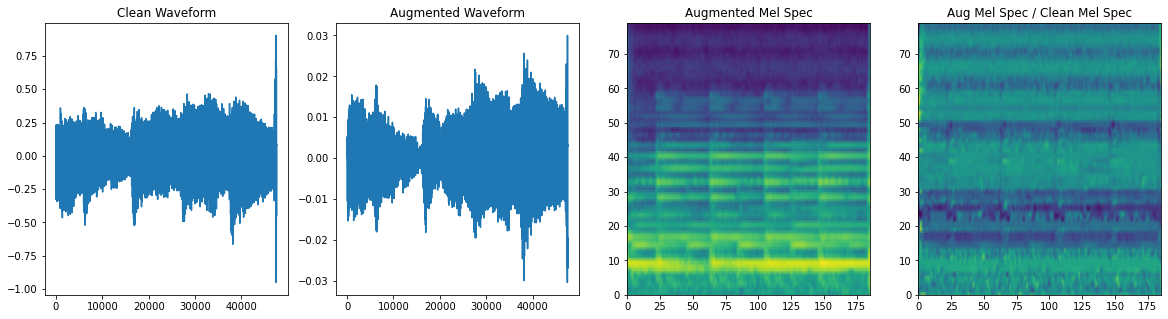

Reverb with DRR of 0.0


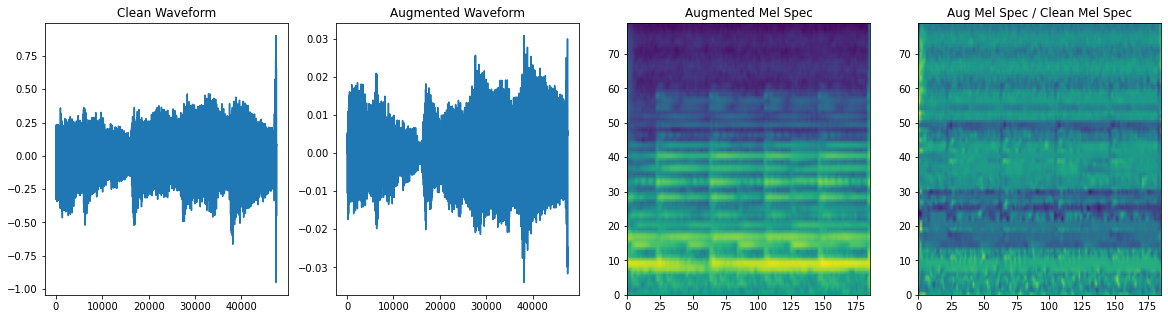

Random EQ sample 0


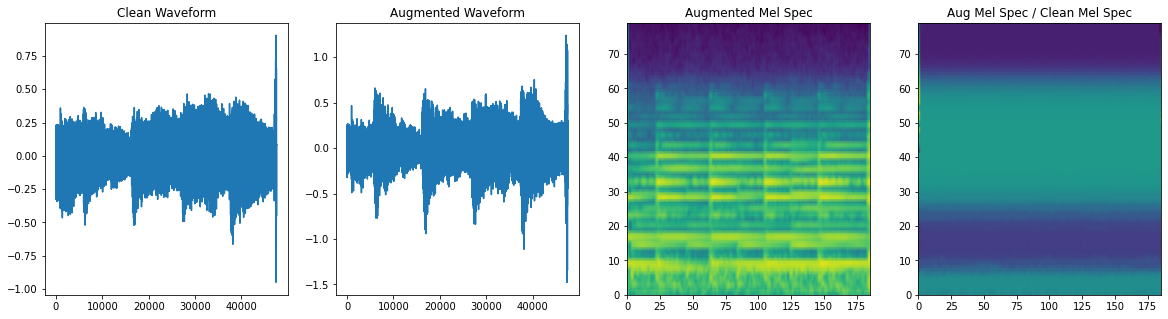

Random EQ sample 1


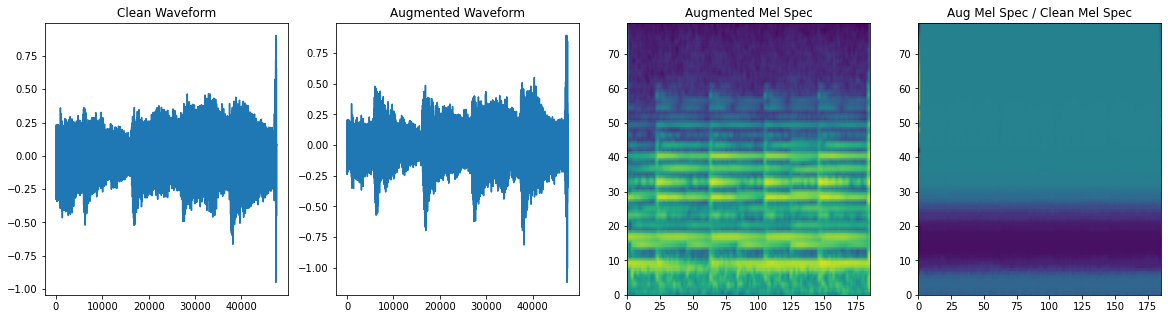

Random EQ sample 2


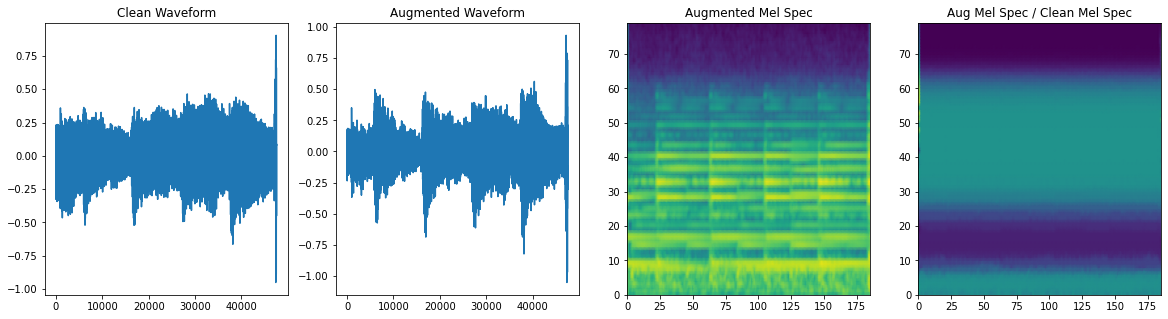

Random EQ sample 3


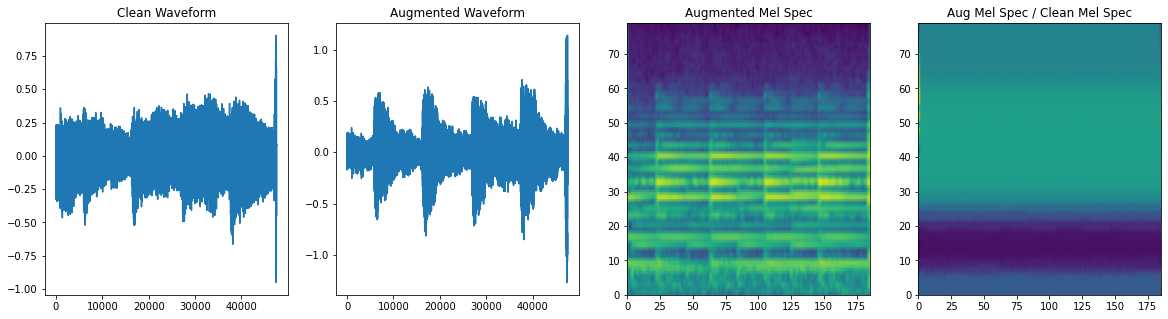

Random EQ sample 4


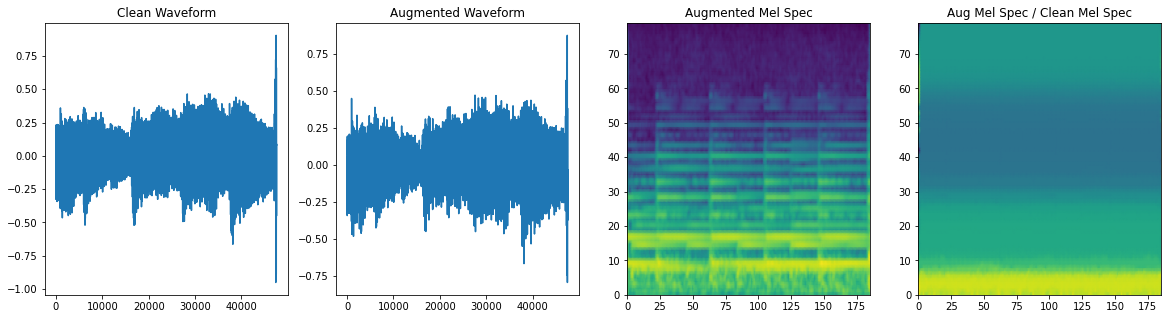

Random EQ sample 5


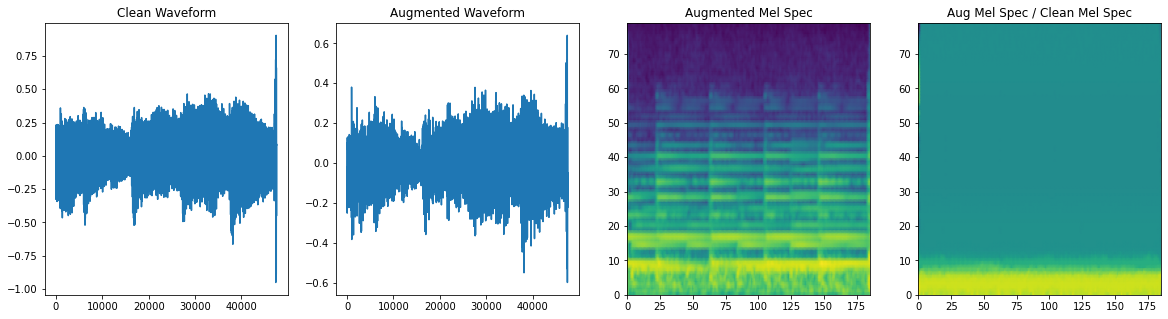

Random Augmented sample 0


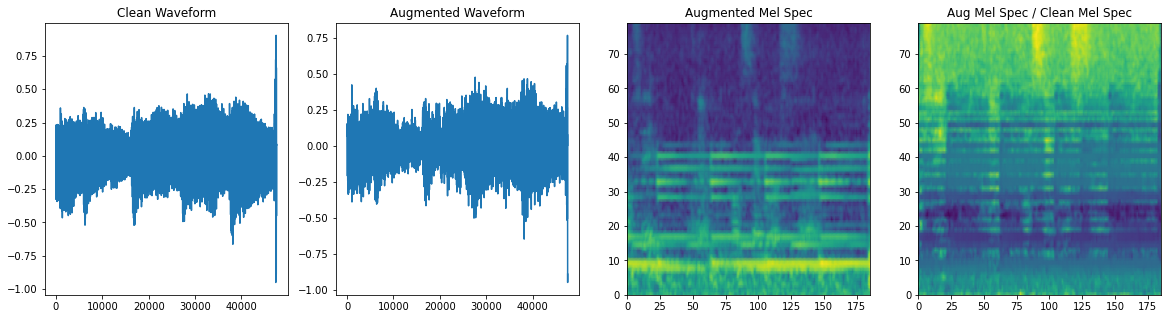

Random Augmented sample 1


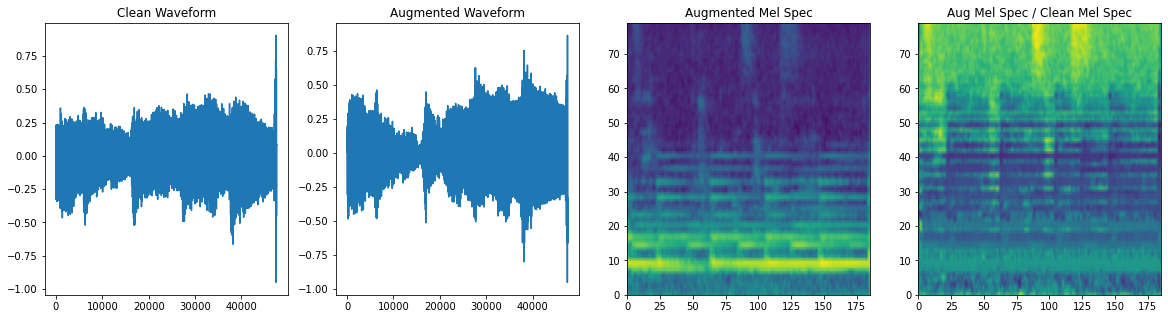

Random Augmented sample 2


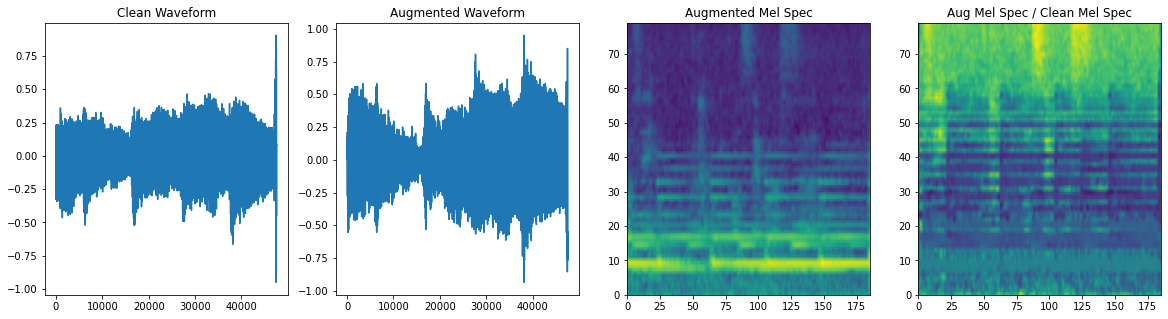

Random Augmented sample 3


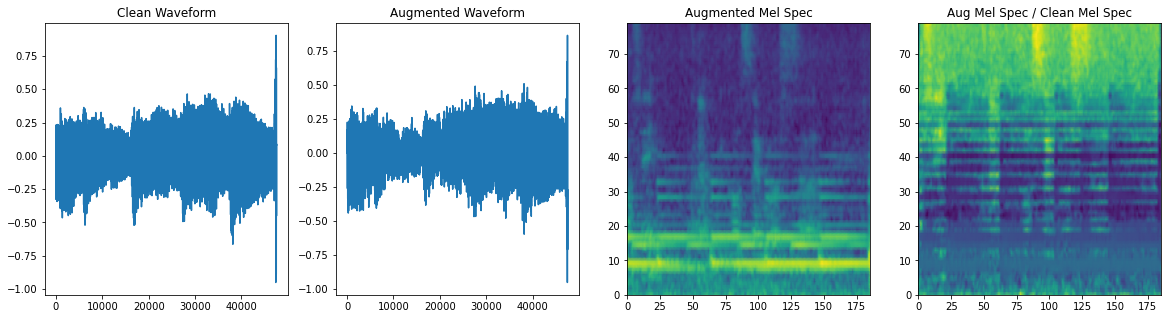

Random Augmented sample 4


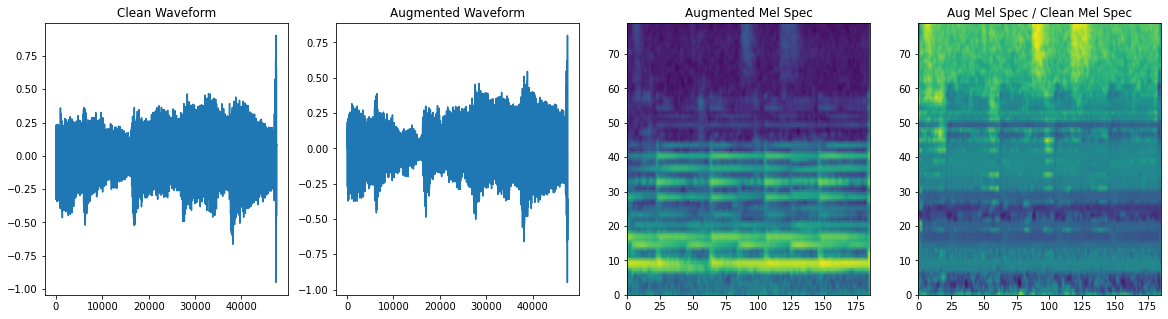

Random Augmented sample 5


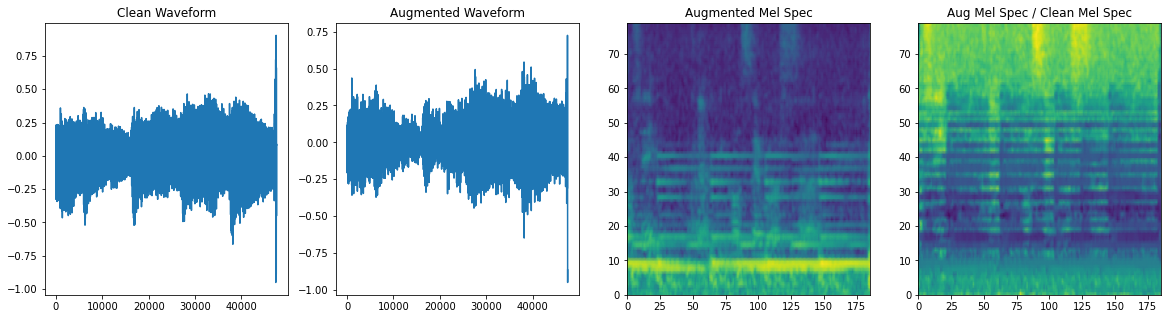

In [6]:
clean_x = next(data_loader)
n = next(noise_loader)
r = next(reverb_loader)

print('Clean Sample')
display(Audio(clean_x.flatten().detach().cpu().numpy(), rate=16000))
clean_spec = spec_transform(clean_x)

print('Noise and Reverb Sample')
n_spec = spec_transform(n)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axes[0].set_title('Additive Noise Sample')
axes[0].plot(n.flatten().detach().cpu().numpy())
axes[1].set_title('Additive Noise Mel Spec')
axes[1].pcolormesh(n_spec[0,0].log2().detach().cpu().numpy(), shading='gouraud')
axes[2].set_title('Room Impulse Response')
axes[2].plot(r.flatten().detach().cpu().numpy())
plt.show()

for nsr in np.linspace(-30,-5,6):
    noisy_x = augmentation.apply_noise(clean_x, n, nsr_target=nsr)
    noisy_spec = spec_transform(noisy_x)
    
    print(f'Additive noise with SNR of {-nsr}')
    display(Audio(noisy_x.flatten().detach().cpu().numpy(), rate=16000))
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    axes[0].set_title('Clean Waveform')
    axes[0].plot(clean_x.flatten().detach().cpu().numpy())
    axes[1].set_title('Augmented Waveform')
    axes[1].plot(noisy_x.flatten().detach().cpu().numpy())
    axes[2].set_title('Augmented Mel Spec')
    axes[2].pcolormesh(noisy_spec[0,0].log2().detach().cpu().numpy(), shading='gouraud')
    axes[3].set_title('Aug Mel Spec / Clean Mel Spec')
    axes[3].pcolormesh((noisy_spec / clean_spec)[0,0].log2().detach().cpu().numpy(), shading='gouraud')
    plt.show()

for drr in np.linspace(15,0,6):
    reverb_x = augmentation.apply_reverb(clean_x, r, drr_target=drr, rate=16000)
    reverb_spec = spec_transform(reverb_x)
    
    print(f'Reverb with DRR of {drr}')
    display(Audio(reverb_x.flatten().detach().cpu().numpy(), rate=16000))
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    axes[0].set_title('Clean Waveform')
    axes[0].plot(clean_x.flatten().detach().cpu().numpy())
    axes[1].set_title('Augmented Waveform')
    axes[1].plot(reverb_x.flatten().detach().cpu().numpy())
    axes[2].set_title('Augmented Mel Spec')
    axes[2].pcolormesh(reverb_spec[0,0].log2().detach().cpu().numpy(), shading='gouraud')
    axes[3].set_title('Aug Mel Spec / Clean Mel Spec')
    axes[3].pcolormesh((reverb_spec / clean_spec)[0,0].log2().detach().cpu().numpy(), shading='gouraud')
    plt.show()
    
for i in range(6):
    eq_x = eq_model(clean_x)
    eq_spec = spec_transform(eq_x)
    
    print(f'Random EQ sample {i}')
    display(Audio(eq_x.flatten().detach().cpu().numpy(), rate=16000))
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    axes[0].set_title('Clean Waveform')
    axes[0].plot(clean_x.flatten().detach().cpu().numpy())
    axes[1].set_title('Augmented Waveform')
    axes[1].plot(eq_x.flatten().detach().cpu().numpy())
    axes[2].set_title('Augmented Mel Spec')
    axes[2].pcolormesh(eq_spec[0,0].log2().detach().cpu().numpy(), shading='gouraud')
    axes[3].set_title('Aug Mel Spec / Clean Mel Spec')
    axes[3].pcolormesh((eq_spec / clean_spec)[0,0].log2().detach().cpu().numpy(), shading='gouraud')
    plt.show()
    
for i in range(6):
    _, aug_x = augmentation.augment(clean_x, rir=r, noise=n, eq_model=eq_model, nsr_range=[-30,-5], drr_range=[0,15], normalize=True)
    aug_spec = spec_transform(aug_x)
    
    print(f'Random Augmented sample {i}')
    display(Audio(aug_x.flatten().detach().cpu().numpy(), rate=16000))
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    axes[0].set_title('Clean Waveform')
    axes[0].plot(clean_x.flatten().detach().cpu().numpy())
    axes[1].set_title('Augmented Waveform')
    axes[1].plot(aug_x.flatten().detach().cpu().numpy())
    axes[2].set_title('Augmented Mel Spec')
    axes[2].pcolormesh(aug_spec[0,0].log2().detach().cpu().numpy(), shading='gouraud')
    axes[3].set_title('Aug Mel Spec / Clean Mel Spec')
    axes[3].pcolormesh((aug_spec / clean_spec)[0,0].log2().detach().cpu().numpy(), shading='gouraud')
    plt.show()

In [ ]:
direct_ir, reverb_ir = augmentation.decompose_rir(r)

In [ ]:
direct_ir.shape, reverb_ir.shape

In [ ]:
plt.plot(direct_ir.flatten())

In [ ]:
plt.plot(torch.cat((direct_ir, reverb_ir), axis=-1).flatten()[0:1000])

In [ ]:
drr_db = augmentation.drr(direct_ir, reverb_ir)
drr_db

In [ ]:
scale = 10**((drr_db - 5)/20)
scale

In [ ]:
augmentation.drr(direct_ir, scale[:,None,None]*reverb_ir)

In [ ]:
plt.plot(torch.cat((direct_ir, scale[:,None,None]*reverb_ir), axis=-1).flatten()[0:1000])

In [ ]:
x = torch.randn(1,1,1000)
conv = nn.Conv1d(1, 2, 129, padding=64)
y = conv(x)

In [ ]:
y.shape

In [ ]:
(y - conv.bias[None,:,None])/x

In [ ]:
test_signal = torch.ones_like(clean_x)

In [ ]:
plt.plot(test_signal.detach().cpu().flatten())

In [ ]:
plt.plot(eq_model(test_signal).detach().cpu().flatten())